In [1]:
from pcntoolkit.util.hbr_utils import *
import numpy as np
import pickle
from matplotlib import pyplot as plt
from pcntoolkit.util.utils import scaler
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
features = ['Right-Cerebellum-White-Matter',
            'EstimatedTotalIntraCranialVol',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem']


selected_feature = features[3]

In [3]:
# Get data
X_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_train.pkl",'rb')).to_numpy()
Y_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_train.pkl",'rb'))
Z_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_train.pkl",'rb')).to_numpy()
X_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_test.pkl",'rb')).to_numpy()
Y_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_test.pkl",'rb'))
Z_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_test.pkl",'rb')).to_numpy()

In [6]:
def plot_MAP_quantiles(fold = 0, feature ="Right-Lateral-Ventricle", l='SHASHb',selected_sex='male'):
    f_idx = features.index(feature)
    
    # map_path  = f'10_folds_results/MAPS/MAP_{f_idx}_{l}_fold{fold}_sexcov.pkl'
# #     map_path = f"compare_linear_epsilon_and_delta_wdir/MAP_lifespan_{feature}_SHASHb_{postfix1}_{postfix2}.pkl"
#     with open(map_path,'rb') as file:
#         MAP = pickle.load(file)
    model_path = f'10_folds_results/fold_{fold}_{l}_sexcov/batch_{f_idx+1}/Models/NM_0_0_fold{fold}{l}sexcov.pkl'
    with open(model_path,'rb') as file:
        model = pickle.load(file)
    
    this_Y_train = Y_train[feature].to_numpy()
    this_Y_test = Y_test[feature].to_numpy()
    inscaler = scaler("standardize")
    outscaler = scaler("standardize")
    this_scaled_X_train = inscaler.fit_transform(X_train)
    this_scaled_Y_train = outscaler.fit_transform(this_Y_train)
    this_scaled_X_test = inscaler.transform(X_test)
    this_scaled_Y_test = outscaler.transform(this_Y_test)
    
    selected_sex_id = 0 if selected_sex == 'female' else 1
    train_sex_idx = np.where(X_train[:,1]==selected_sex_id)
    test_sex_idx = np.where(X_test[:,1]==selected_sex_id)

    # select a model batch effect (69,1)
    model_be = [69]
    mu_intercept_mu = MAP['mu_intercept_mu'].item()
    sigma_intercept_mu = MAP['sigma_intercept_mu'].item()
    offsets = MAP['offset_intercept_mu']
    model_offset_intercept_mu_be = offsets[model_be]

    
    # Make an empty array
    centered_Y_train = np.zeros_like(this_scaled_Y_train)
    centered_Y_test = np.zeros_like(this_scaled_Y_test)
    
    # For each batch effect
    for be in np.unique(Z_train,axis = 0):
        this_offset_intercept = offsets[be]
        idx = (Z_train == be).all(1) 

        centered_Y_train[idx] = this_scaled_Y_train[idx]-sigma_intercept_mu*this_offset_intercept
        idx = (Z_test == be).all(1) 
        centered_Y_test[idx] = this_scaled_Y_test[idx]-sigma_intercept_mu*this_offset_intercept

    fig = plt.figure(figsize=(5,4))

    plt.scatter(inscaler.inverse_transform(this_scaled_X_train)[train_sex_idx,0], outscaler.inverse_transform(centered_Y_train[train_sex_idx,None]), alpha = 0.1, s = 12, color=cols[0])
    plt.scatter(inscaler.inverse_transform(this_scaled_X_test)[test_sex_idx,0], outscaler.inverse_transform(centered_Y_test[test_sex_idx,None]), alpha = 0.1, s = 12, color=cols[1])
    
    min0 = np.min(this_scaled_X_train[:,0])+0.2
    max0 = np.max(this_scaled_X_train[:,0])-0.2
    sex = np.unique(this_scaled_X_train[:,1])[selected_sex_id]
    synthetic_X0 = np.linspace(min0, max0, 200)[:,None]
    
    synthetic_X = np.concatenate((synthetic_X0, np.full(synthetic_X0.shape,sex)),axis = 1)
    ran = np.arange(-3,4)
    
    # q = get_MCMC_quantiles(synthetic_X,ran, model, model_be)-sigma_intercept_mu*offsets[tuple(model_be)]
    q = model.get_mcmc_quantiles(synthetic_X, model_be, zscores = np.arange(-3,4)) - sigma_intercept_mu*offsets[tuple(model_be)]
    q = outscaler.inverse_transform(q)
    
    x = inscaler.inverse_transform(synthetic_X)
    
    for ir, r in enumerate(ran):
        if r == 0:
            plt.plot(x[:,0], q[:,ir], color = 'black')
        elif abs(r) == 3:
            plt.plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linestyle="--", linewidth = 1)

        else:
            plt.plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linewidth = 1)
    plt.title(feature, fontsize=15, y = 1.07)
    plt.xlabel('Age',fontsize=12)
#     plt.ylabel(feature,fontsize=12)
    plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0),useMathText=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    

    plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/MCMC_quantile_plot_{feature}_{l}.png",dpi=300)
    plt.show()


In [7]:
for f in features:
    plot_MAP_quantiles(l='Normal', feature=f)
    plot_MAP_quantiles(l='SHASHb', feature=f)

# plot_MAP_quantiles(postfix2='True',feature=selected_feature, selected_sex = 'female')

FileNotFoundError: [Errno 2] No such file or directory: '10_folds_results/fold_0_Normal_sexcov/batch_1/Models/NM_0_0_fold0Normalsexcov.pkl'

In [ ]:
plot_MAP_quantiles(postfix2='True', selected_sex = 'male')
plot_MAP_quantiles(postfix2='True', selected_sex = 'female')

(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)


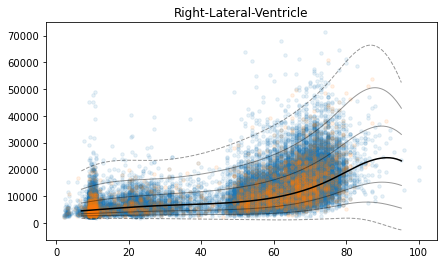

In [11]:
plot_MAP_quantiles(l = 'SHASHb',feature=  'Right-Lateral-Ventricle')

In [10]:
dim1 = 10

all_bes = np.unique(np.random.randint(0,dim1,size=(10,2)), axis = 0)

az = np.random.randn(dim1, dim1)
for be in all_bes:
    print(be)
    
    bet = tuple(be)
    print(az[bet])

[0 0]
0.8975569670019615
[0 5]
-0.7372921940388589
[2 6]
0.2926387619774334
[3 0]
0.5139866033288966
[3 2]
0.3198717260198283
[5 0]
0.010077214480161646
[5 4]
-1.8668029316129853
[8 4]
-0.4144231171312049
[8 5]
1.1591333558913104
[9 2]
-0.034921078527202644
